Processing file: https://raw.githubusercontent.com/WolfgangDrescher/lassus-geistliche-psalmen/master/kern/08-domine-dominus-noster.krn




,Measure,Local Onset,Duration,Pitch,MIDI
0,1,0.0,4.0,D5,74
1,1,2.0,2.0,D4,62
2,1,4.0,2.0,D5,74
3,1,4.0,1.0,D4,62
4,1,5.0,1.0,E4,64
...,...,...,...,...,...
227,22,174.0,2.0,C#4,61
228,22,174.0,2.0,A3,57
229,23,176.0,8.0,F#4,66
230,23,176.0,8.0,D4,62


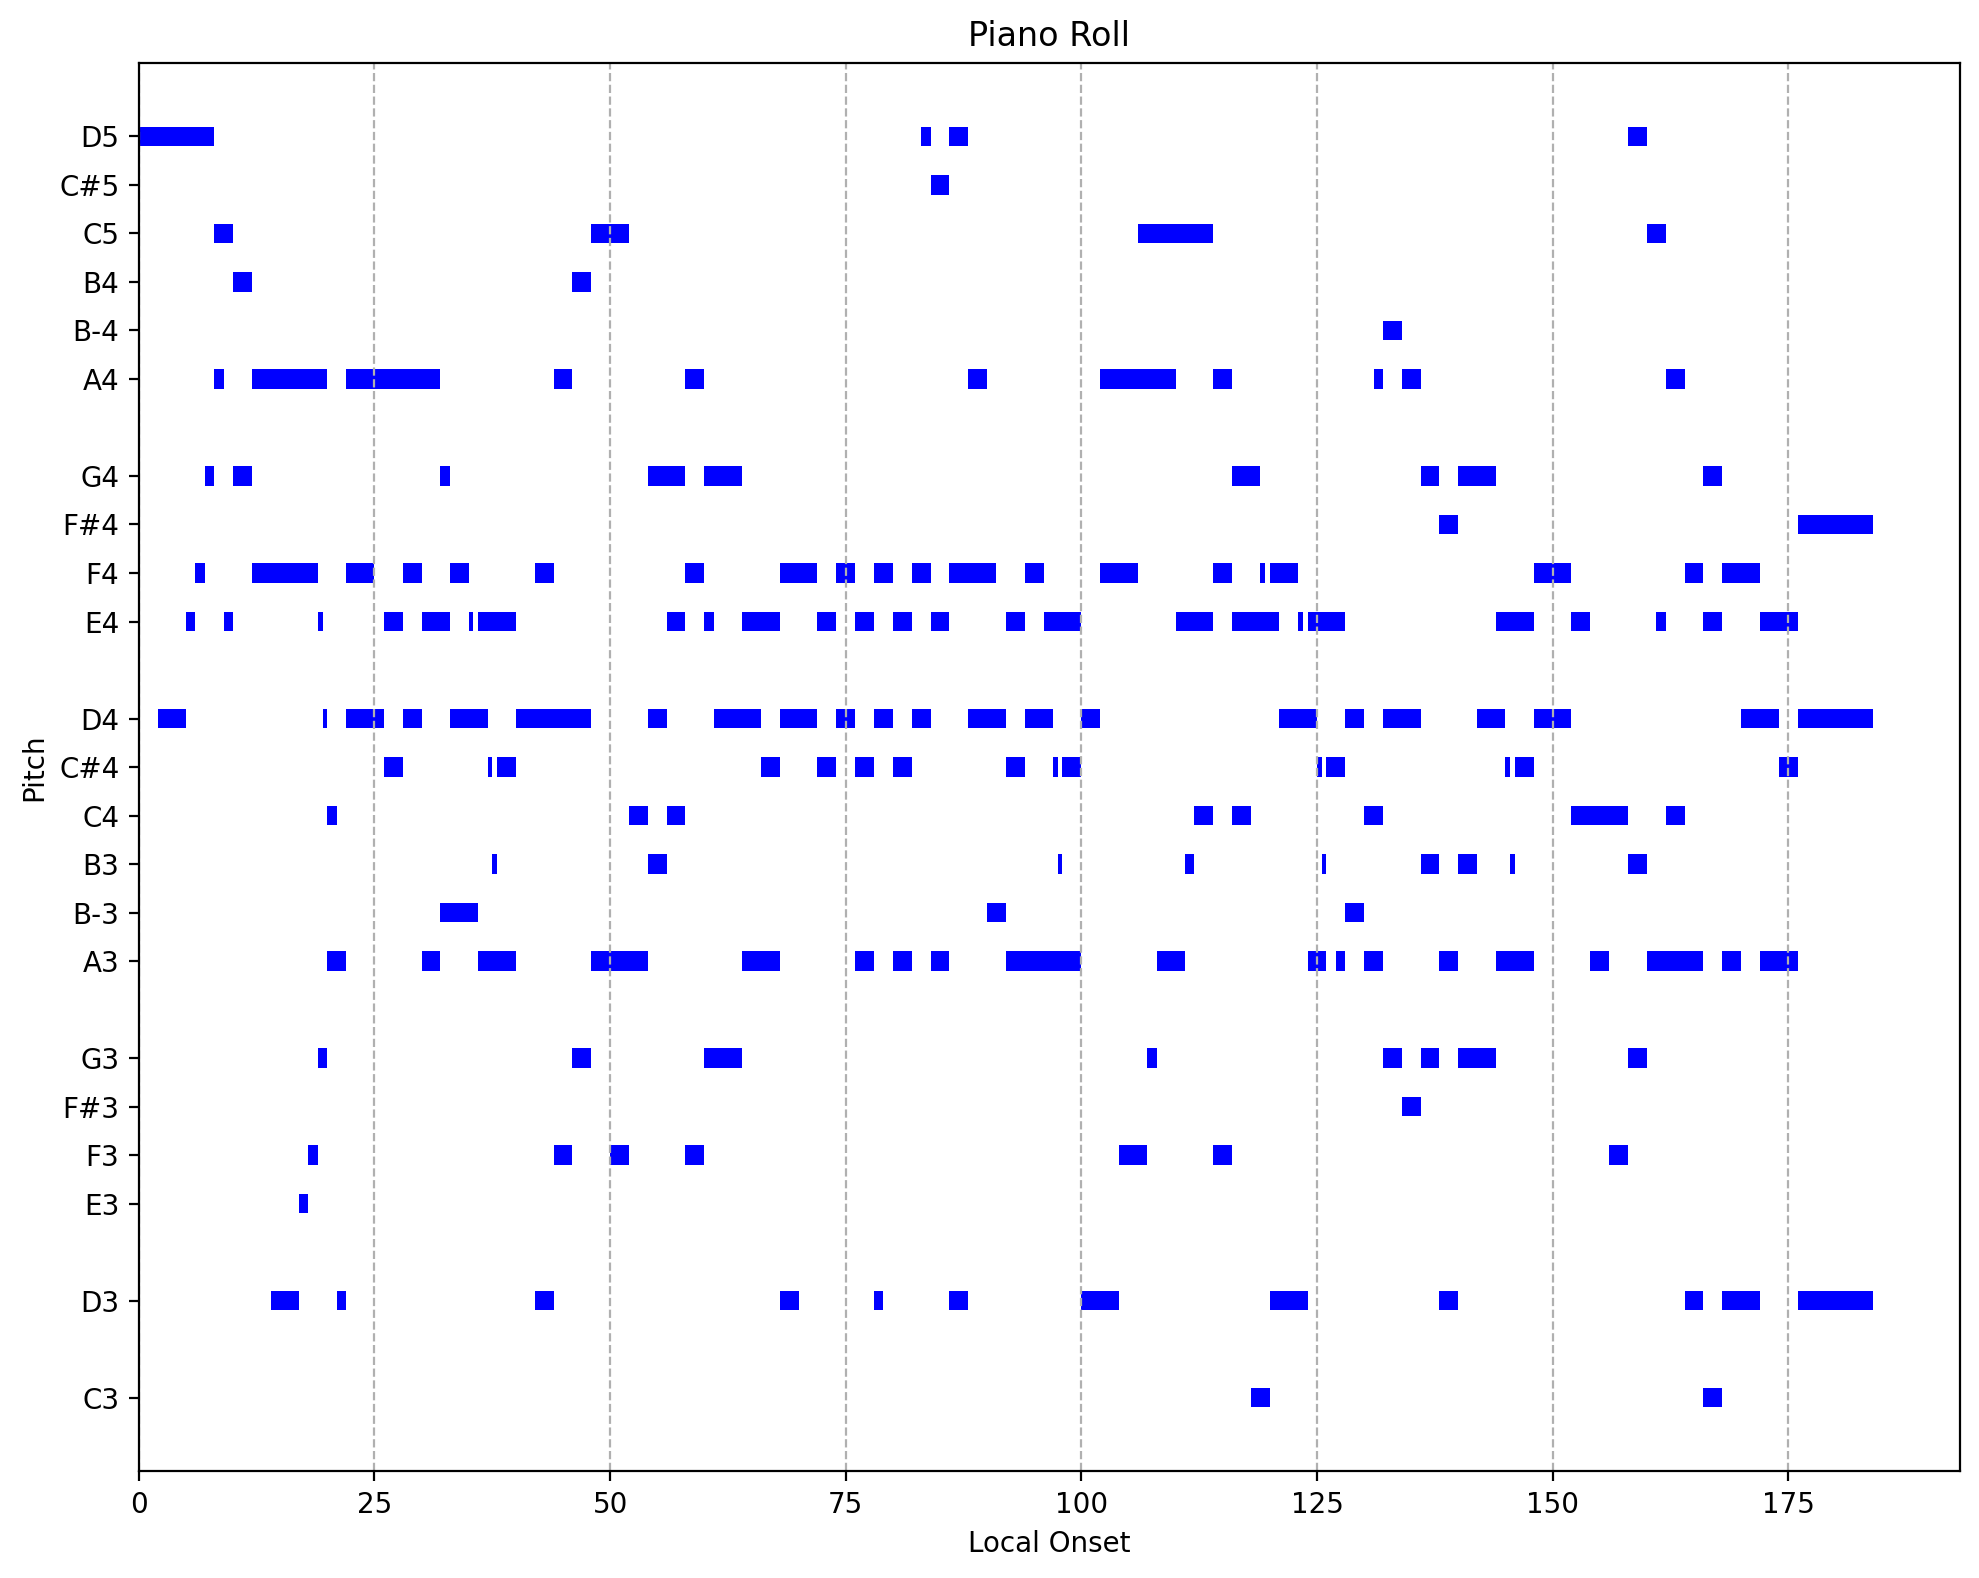

In [1]:
from music21 import converter, note, chord
from music21 import pitch as pitch_module
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tempfile
import os

def get_file_path(file_source):
    """
    Determines the nature of the file_source (URL or local path). If it's a URL, the content is
    downloaded and saved to a temporary file, whose path is returned. If a local path, it verifies
    the file exists and returns the path.

    Parameters
    ----------
    file_source : str
        The source of the file, either a URL or a local file path.

    Returns
    -------
    str
        The path to the local file.

    Raises
    ------
    ValueError
        If there is an error downloading the file from a URL.
    FileNotFoundError
        If the specified local file does not exist.
    """
    if file_source.startswith(('http://', 'https://')):
        try:
            with requests.get(file_source) as response:
                response.raise_for_status()
                _, file_extension = os.path.splitext(file_source)
                with tempfile.NamedTemporaryFile(delete=False, suffix=file_extension) as temp_file:
                    temp_file.write(response.content)
                    return temp_file.name
        except requests.RequestException as e:
            raise ValueError(f"Error downloading the file: {e}")
    else:
        if os.path.exists(file_source):
            return file_source
        else:
            raise FileNotFoundError("Local file does not exist")

def extract_voice_data(score):
    """
    Extracts and aggregates note and chord information from a music21 score object. For chords,
    each constituent note is treated individually.

    Parameters
    ----------
    score : music21.stream.Score
        The music21 score object from which to extract note and chord information.

    Returns
    -------
    list of tuple
        A list of tuples, each containing measure number, position within measure, duration in
        quarter lengths, and pitch as a string.
    """
    voice_data = []
    notes_and_chords = score.flatten().notesAndRests.stream()

    for element in notes_and_chords:
        if isinstance(element, (note.Note, chord.Chord)):
            measure_num = element.measureNumber
            position_within_measure = element.offset
            duration = element.duration.quarterLength
            pitches = [str(element.pitch)] if isinstance(element, note.Note) else [str(p) for p in element.pitches]
            voice_data.extend([(measure_num, position_within_measure, duration, pitch) for pitch in pitches])

    return voice_data

def create_piano_roll(df):
    """
    Creates a piano roll visualization from a DataFrame containing musical note data. This version
    ensures that the y-axis labels match the number of MIDI pitch values present in the DataFrame,
    addressing the previous mismatch issue.

    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame with columns 'Measure', 'Local Onset', 'Duration', 'Pitch', and 'MIDI',
        containing musical note data for plotting.
    """
    # Generate a consistent pitch name for each MIDI value to ensure matching tick labels
    midi_to_pitch = {midi: pitch for midi, pitch in zip(df['MIDI'], df['Pitch'])}
    
    plt.figure(figsize=(10, 8))
    for index, row in df.iterrows():
        plt.barh(row['MIDI'], width=row['Duration'], left=row['Local Onset'], height=0.4, color='blue')
    
    # Use the consistent MIDI to pitch mapping for labeling
    plt.yticks(list(midi_to_pitch.keys()), list(midi_to_pitch.values()))
    plt.xlabel('Local Onset')
    plt.ylabel('Pitch')
    plt.title('Piano Roll')
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()


def filter_and_adjust_durations(df, filter_zero_duration=True, adjust_fractional_duration=True):
    """
    Filters out notes with 0 duration and adjusts fractional durations in the DataFrame. 
    Also ensures 'Duration' and 'Local Onset' are converted to floats for JSON serialization.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to process.
    filter_zero_duration : bool, optional
        If True, filters out notes with 0 duration. Default is True.
    adjust_fractional_duration : bool, optional
        If True, rounds fractional durations to the nearest whole number. Default is True.

    Returns
    -------
    pandas.DataFrame
        The processed DataFrame.
    """
    # Create a copy to avoid modifying the original DataFrame directly
    df_processed = df.copy()

    if filter_zero_duration:
        df_processed = df_processed[df_processed['Duration'] > 0]

    if adjust_fractional_duration:
        df_processed['Duration'] = df_processed['Duration'].apply(lambda x: round(x, 3))
        df_processed['Local Onset'] = df_processed['Local Onset'].apply(lambda x: round(x, 3))

    return df_processed


filter_zero_duration = True  # Set to False if you want to keep notes with 0 duration
adjust_fractional_duration = False  # Set to False if you want to keep fractional durations as is

# Define a list or dictionary of file sources.

file_sources = [
    #'C://Users//egorp//Nextcloud//code//playground//wtc1f08.mid',
    'https://raw.githubusercontent.com/WolfgangDrescher/lassus-geistliche-psalmen/master/kern/08-domine-dominus-noster.krn',
    #'https://raw.githubusercontent.com/music-encoding/sample-encodings/main/MEI_4.0/Music/Complete_examples/Chopin_Etude_Op10_No9.mei'
]

try:
    for file_source in file_sources:
        print(f"Processing file: {file_source}")
        print("\n") 
        file_path = get_file_path(file_source)
        score = converter.parse(file_path)
        voice_data = extract_voice_data(score)
        df = pd.DataFrame(voice_data, columns=['Measure', 'Local Onset', 'Duration', 'Pitch'])
        
                # Apply MIDI Pitch Conversion with Error Handling
        try:
            df['MIDI'] = df['Pitch'].apply(lambda x: pitch_module.Pitch(x).midi)
        except Exception as e:
            print(f"Error converting pitch to MIDI: {e}")
            continue
        
        # Process the DataFrame to adjust durations and convert data types
        df_processed = filter_and_adjust_durations(df, filter_zero_duration, adjust_fractional_duration)
        
        # Display the processed DataFrame. Adjust if not applicable for your environment.
        display(df_processed)  # Make sure to use df_processed
        
        create_piano_roll(df_processed)  # Ensure to pass the processed DataFrame
        
        # Break after the first successful execution to prevent processing all file sources.
        break

except Exception as e:
    print(f"An error occurred: {e}")


In [2]:
# Find and print out the row with smallest duration (useful for setting up the resolution of SSM plot)

min_duration_index = df_processed['Duration'].idxmin()

print(f"Row with the minimum duration: {min_duration_index}")
print("\n") 
print(df.loc[min_duration_index])

Row with the minimum duration: 21


Measure           3
Local Onset    19.0
Duration        0.5
Pitch            E4
MIDI             64
Name: 21, dtype: object


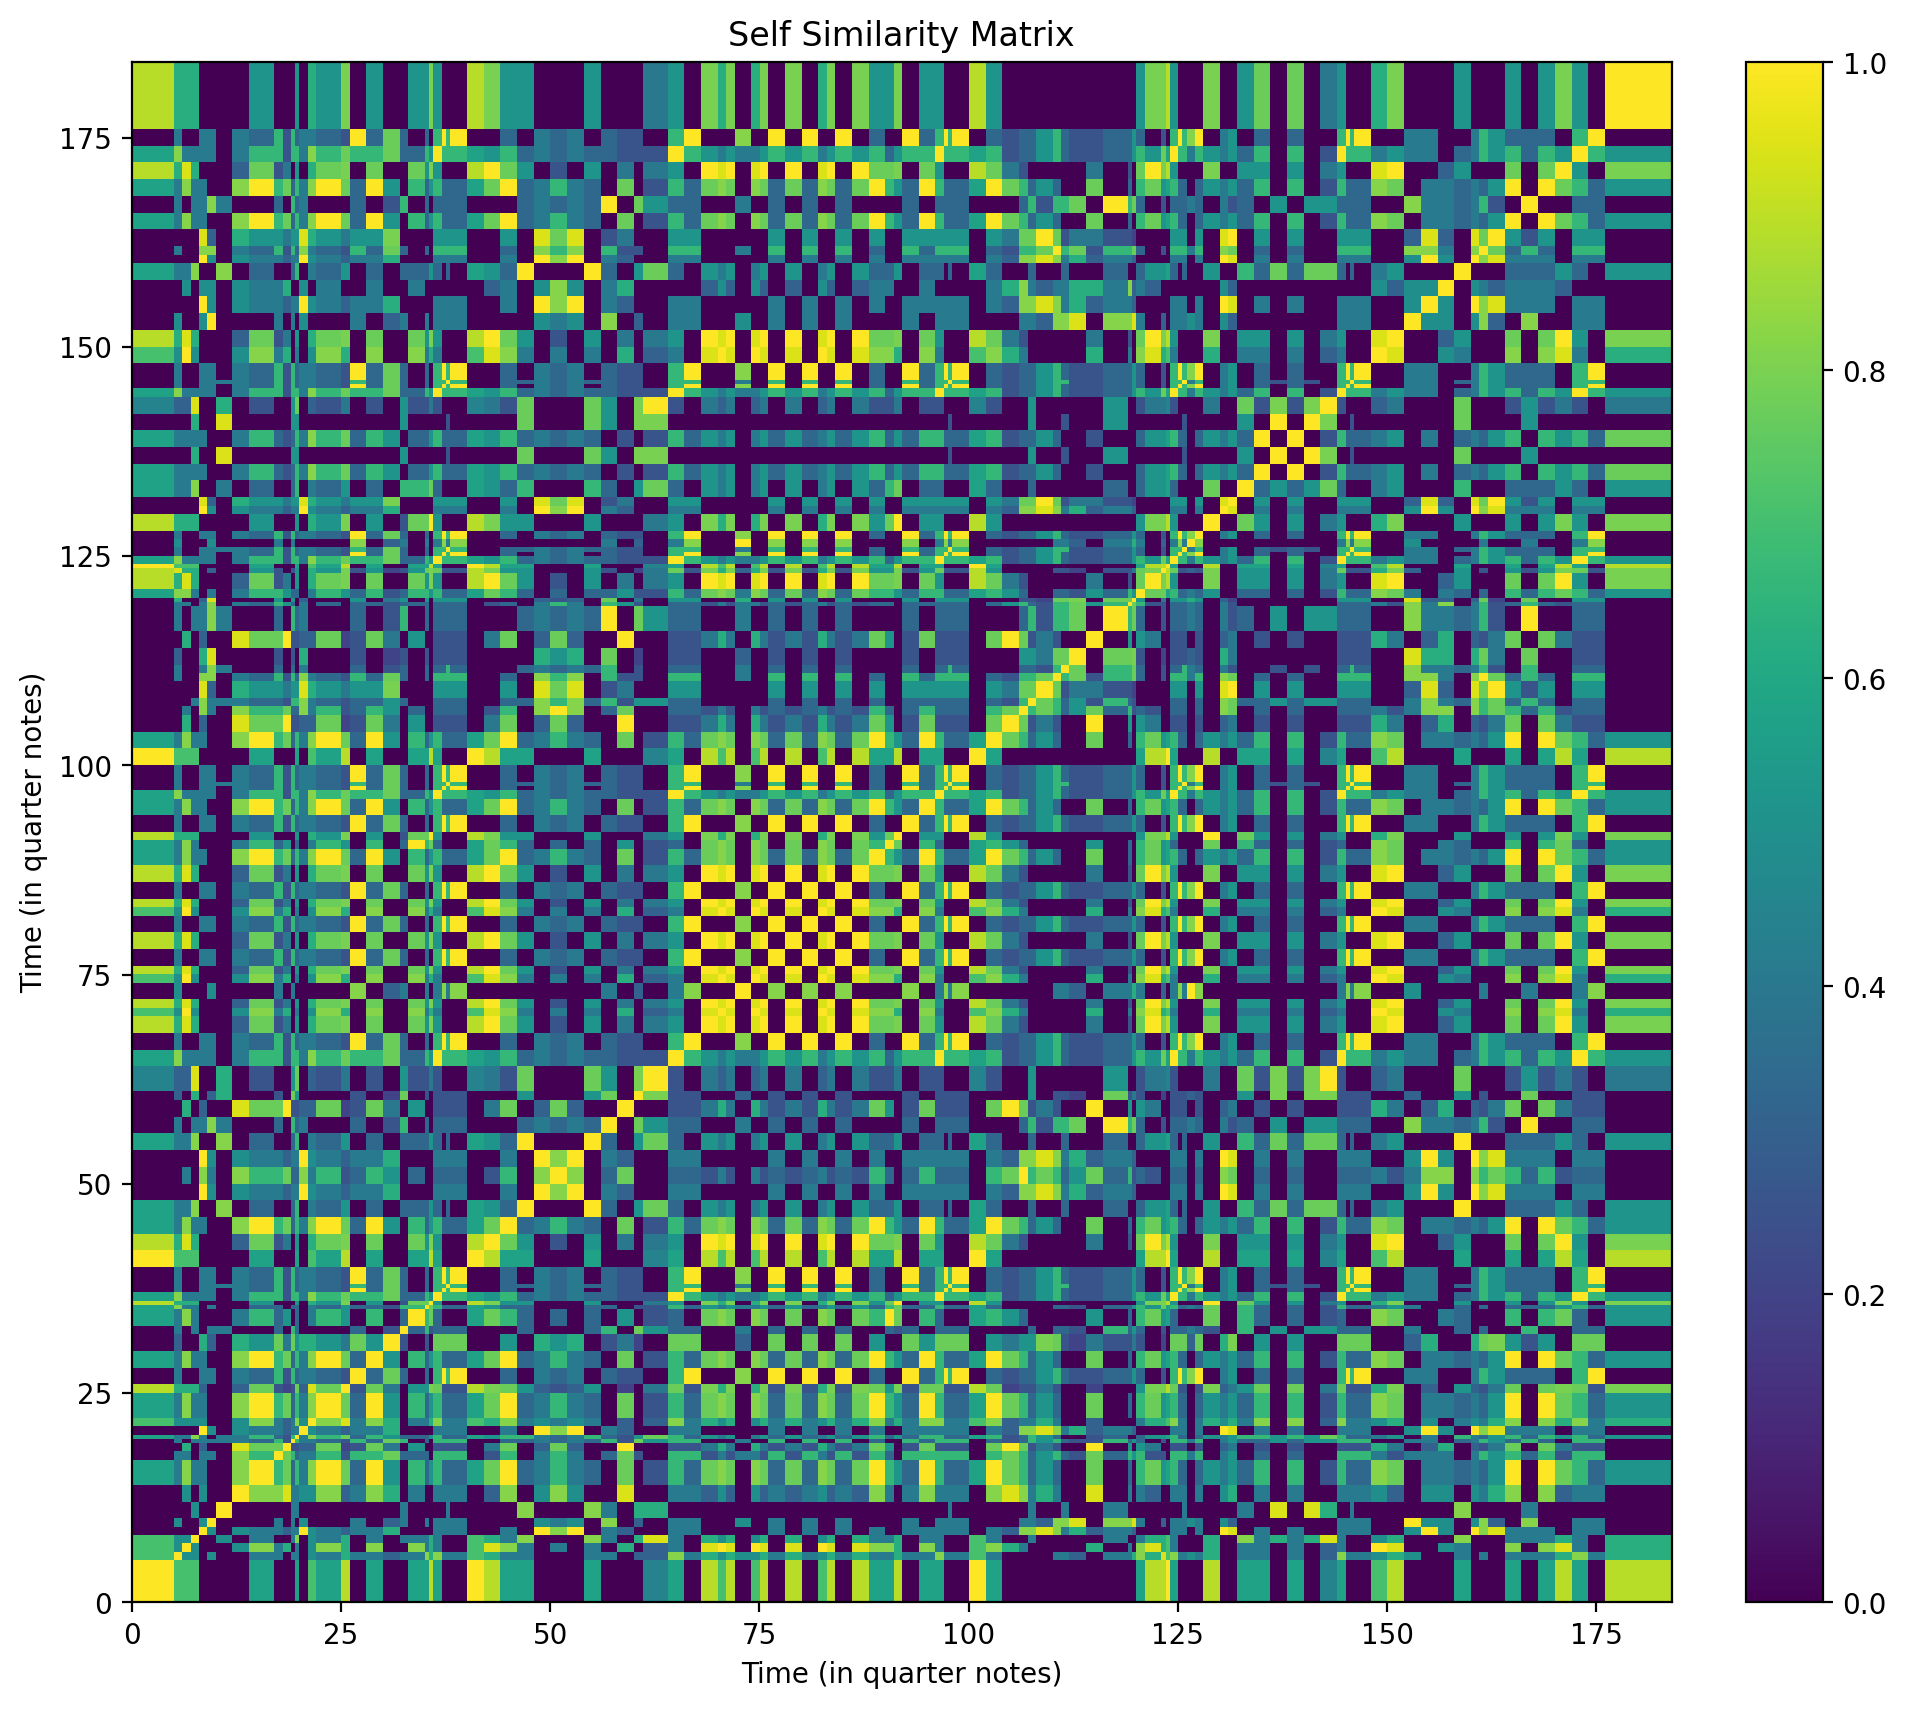

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import convolve2d

def aggregate_pitch_classes_from_df(df, analysis_window):
    """
    Aggregates pitch classes from a DataFrame within specified analysis windows.
    This function calculates the occurrence of each pitch class (0-11) for MIDI notes
    active in each time window, creating a time series of pitch class distributions.

    Parameters:
    - df (pd.DataFrame): DataFrame containing musical note data with columns for 'Local Onset',
                         'Duration', and 'MIDI' note numbers.
    - analysis_window (float): Duration of each analysis window in the same time unit as 'Local Onset'.

    Returns:
    - list: A list of numpy arrays, each representing the pitch class distribution within a time window.
    """
    # Calculate the total duration to cover all notes in the DataFrame
    max_time = df['Local Onset'].max() + df['Duration'].max()
    num_windows = int(np.ceil(max_time / analysis_window))
    
    aggregated_pitch_classes = []
    for window_start in np.arange(0, num_windows * analysis_window, analysis_window):
        # Select notes that are active during the current window
        window_df = df[(df['Local Onset'] < window_start + analysis_window) & ((df['Local Onset'] + df['Duration']) > window_start)]
        
        pitch_classes = window_df['MIDI'] % 12
        pitch_class_vector = np.zeros(12)
        np.add.at(pitch_class_vector, pitch_classes, 1)  # Vectorized operation to count occurrences
        
        aggregated_pitch_classes.append(pitch_class_vector)

    return aggregated_pitch_classes

def create_self_similarity_matrix(aggregated_pitch_classes):
    """
    Creates a self-similarity matrix from aggregated pitch class vectors using cosine similarity.

    Parameters:
    - aggregated_pitch_classes (list): A list of numpy arrays with pitch class distributions.

    Returns:
    - np.ndarray: A square matrix of cosine similarity values representing the self-similarity of the input.
    """
    vectors = np.array(aggregated_pitch_classes)
    similarity_matrix = cosine_similarity(vectors)
    return similarity_matrix

def plot_self_similarity_matrix(matrix, analysis_window, figsize=(12, 10)):
    """
    Plots the self-similarity matrix (SSM) with a specified analysis window size.

    Parameters:
    - matrix (np.ndarray): The self-similarity matrix to be plotted.
    - analysis_window (float): The analysis window size in quarter notes.
    - figsize (tuple): The figure size for the plot.

    The function creates a plot representing the SSM, including appropriate labels and a colorbar.
    """
    plt.figure(figsize=figsize)  # Configurable figure size
    extent = [0, len(matrix) * analysis_window, 0, len(matrix) * analysis_window]
    
    ax = plt.gca()
    im = ax.imshow(matrix, cmap='viridis', aspect='equal', extent=extent, origin='lower')
    
    plt.title('Self Similarity Matrix')
    plt.xlabel('Time (in quarter notes)')
    plt.ylabel('Time (in quarter notes)')
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.show()


def diagonal_smooth(mat, width):
    """
    Applies diagonal smoothing to a matrix using convolution with a normalized identity matrix.

    Parameters:
    - mat (np.ndarray): The matrix to be smoothed.
    - width (int): The width of the smoothing kernel (identity matrix).

    Returns:
    - np.ndarray: The diagonally smoothed matrix.
    """
    if width <= 1:
        return mat
    kernel = np.eye(width)
    kernel /= kernel.sum()
    smoothed = convolve2d(mat, kernel, mode='same', boundary='symm')
    return smoothed

# Analysis window size in quarter notes
analysis_window = 0.5  # 1 equals one quarter note

# Processing
aggregated_pitch_classes = aggregate_pitch_classes_from_df(df_processed, analysis_window)
self_similarity_matrix = create_self_similarity_matrix(aggregated_pitch_classes)

# Smoothing and plotting
width = 1 # Define the width of your smoothing kernel

self_similarity_matrix_smoothed = diagonal_smooth(self_similarity_matrix, width)
plot_self_similarity_matrix(self_similarity_matrix_smoothed, analysis_window)
